<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install wandb

In [ ]:
import wandb
wandb.login()

In [11]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [12]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [13]:
WINDOW_SIZE = 5
X, y = df_to_X_y(df['% Silica Concentrate'], WINDOW_SIZE)
X.shape, y.shape

((3800, 5, 1), (3800,))

In [14]:
# 70% 15% 15%

X_train, y_train = X[:2664], y[:2664]
X_test, y_test = X[2664:3235], y[2664:3235]
X_val, y_val = X[3235:], y[3235:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2664, 5, 1), (2664,), (571, 5, 1), (571,), (565, 5, 1), (565,))

In [15]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

In [ ]:
sweep_lstm_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "mean_squared_error",
      "goal": "minimize"   
    },
    "parameters": {
          "learning_rate": {
            "values": [0.001, 0.025,  0.005,  0.01]
        },
        "epochs": {
            "values": [50, 100, 200]
        },
        
        "batch_size": {
            "values": [32, 64, 128, 256]
        }
    }
}

sweep_id = wandb.sweep(sweep_lstm_config, project="LSTM_shot_5")

In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

from wandb.keras import WandbCallback

def train():
  config_defaults = {
    "learning_rate": 0.0025,
    "epochs": 100,
    "batch_size": 256,
    'shuffle': False
  }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  #define the model
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1] ,1)))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))

  cp = ModelCheckpoint('model/', save_best_only=True)
  model.compile( loss = MeanSquaredError(), 
                optimizer = Adam(learning_rate=wandb.config['learning_rate']), 
                metrics=['mae',
                        MeanSquaredError(),
                        RootMeanSquaredError(),
                        MeanAbsolutePercentageError()])

  history =  model.fit( X_train,y_train, 
                      validation_data = (X_test,y_test), 
                      epochs = wandb.config['epochs'] , 
                      batch_size = wandb.config['batch_size'],
                      shuffle = wandb.config['shuffle'],
                      callbacks= [cp, 
                                  early_stopping_monitor,
                                  WandbCallback()])
  model.summary()

  
  test_predictions = model.predict(X_test).flatten()
  test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
  mape, mae, rmse = forecast_accuracy(test_results['Test Predictions'], test_results['Actuals'])

  plt.title("Predictions with %s [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (model.__class__.__name__, rmse, mape, mae) )
  wandb.log({"mean_squared_error": rmse})

  wandb.finish()

In [ ]:
wandb.agent(sweep_id, train, count=25)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

#define the model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1] ,1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

cp = ModelCheckpoint('model/', save_best_only=True)
model.compile( loss = MeanSquaredError(), 
                optimizer = Adam(learning_rate= 0.001), 
                metrics=['mae',
                        MeanSquaredError(),
                        RootMeanSquaredError(),
                        MeanAbsolutePercentageError()])

history =  model.fit( X_train,y_train, 
                      validation_data = (X_test,y_test), 
                      epochs = 50, 
                      batch_size = 32,
                      shuffle = False,
                      callbacks= [cp, early_stopping_monitor,])

model.summary()
  
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
mape, mae, rmse = forecast_accuracy(test_results['Test Predictions'], test_results['Actuals'])

print(mape, mae, rmse )

In [19]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})

val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'val Predictions':val_predictions, 'Actuals':y_val})

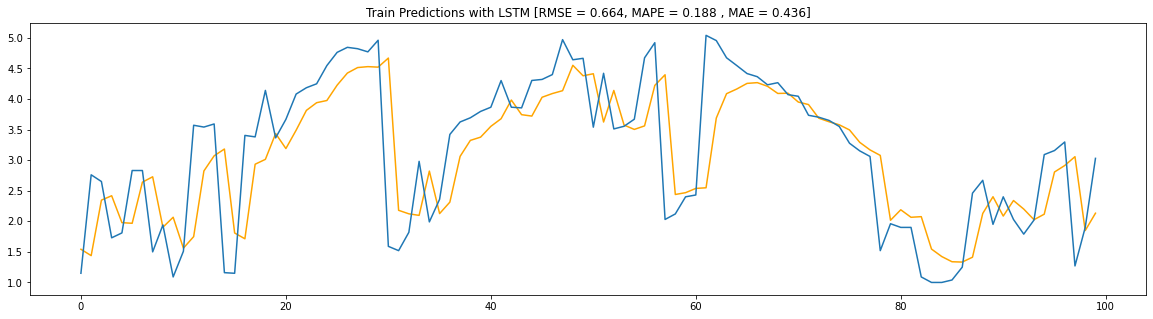

In [20]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(train_results['Train Predictions'], train_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(train_results['Train Predictions'][0:100], color='orange')
plt.plot(train_results['Actuals'][0:100])
plt.title("Train Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

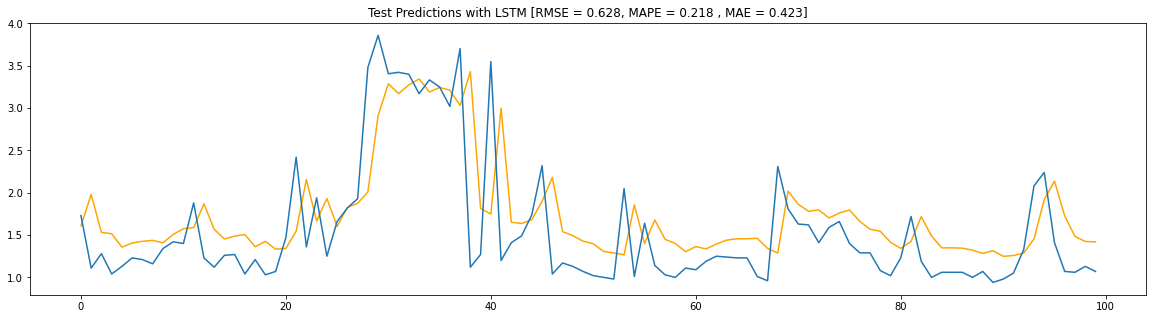

In [21]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(test_results['test Predictions'], test_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(test_results['test Predictions'][0:100], color='orange')
plt.plot(test_results['Actuals'][0:100])
plt.title("Test Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

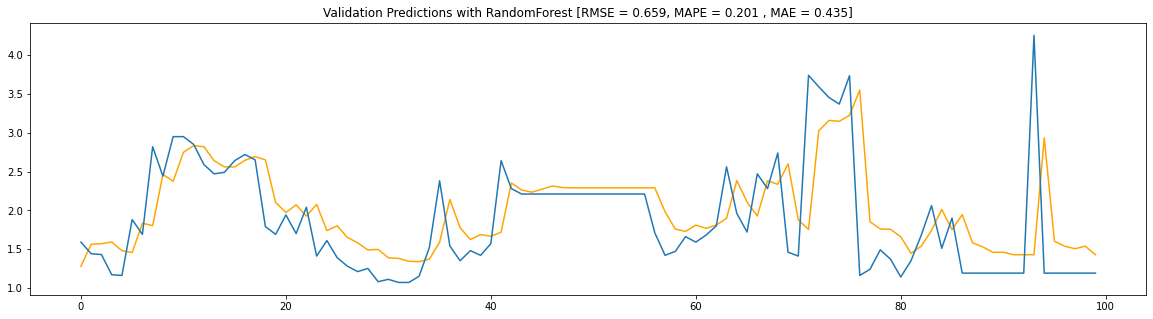

In [22]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(val_results['val Predictions'], val_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(val_results['val Predictions'][0:100], color='orange')
plt.plot(val_results['Actuals'][0:100])
plt.title("Validation Predictions with RandomForest [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

In [23]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'val_loss', 'val_mae', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_percentage_error'])


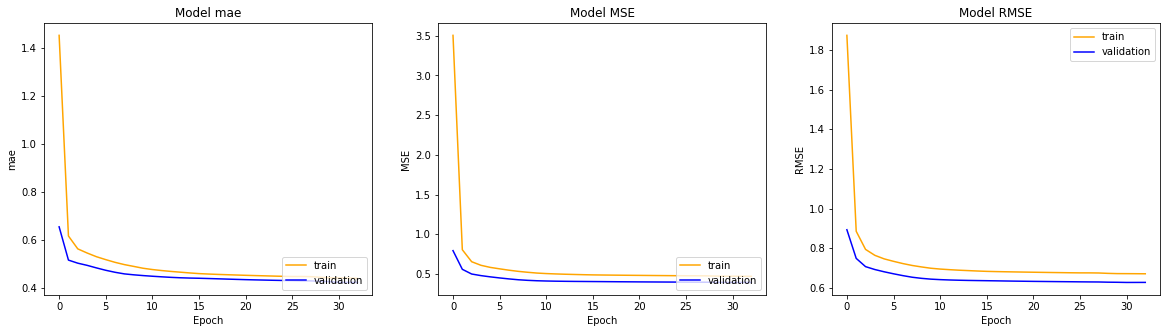

In [24]:
def plot_performance(model_history):
    # modle performance visualization
    # subplot
    fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # mae
    ax1.plot(model_history.history['mae'], color='orange')
    ax1.plot(model_history.history['val_mae'], color='blue')
    ax1.set_title('Model mae')
    ax1.set_ylabel('mae')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    # mean_squared_error
    ax2.plot(model_history.history['mean_squared_error'], color='orange')
    ax2.plot(model_history.history['val_mean_squared_error'], color='blue')
    ax2.set_title('Model MSE')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='lower right')

    # "root_mean_squared_error"
    ax3.plot(model_history.history['root_mean_squared_error'], color='orange')
    ax3.plot(model_history.history['val_root_mean_squared_error'], color='blue')
    ax3.set_title('Model RMSE')
    ax3.set_ylabel('RMSE')
    ax3.set_xlabel('Epoch')
    ax3.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
plot_performance(history)